# Machine Learning Engineer Nanodegree
## Supervised Learning
## Project: Finding Donors for *CharityML*

Welcome to the second project of the Machine Learning Engineer Nanodegree! In this notebook, some template code has already been provided for you, and it will be your job to implement the additional functionality necessary to successfully complete this project. Sections that begin with **'Implementation'** in the header indicate that the following block of code will require additional functionality which you must provide. Instructions will be provided for each section and the specifics of the implementation are marked in the code block with a `'TODO'` statement. Please be sure to read the instructions carefully!

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question X'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.  

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

## Getting Started

In this project, you will employ several supervised algorithms of your choice to accurately model individuals' income using data collected from the 1994 U.S. Census. You will then choose the best candidate algorithm from preliminary results and further optimize this algorithm to best model the data. Your goal with this implementation is to construct a model that accurately predicts whether an individual makes more than $50,000. This sort of task can arise in a non-profit setting, where organizations survive on donations.  Understanding an individual's income can help a non-profit better understand how large of a donation to request, or whether or not they should reach out to begin with.  While it can be difficult to determine an individual's general income bracket directly from public sources, we can (as we will see) infer this value from other publically available features. 

The dataset for this project originates from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Census+Income). The datset was donated by Ron Kohavi and Barry Becker, after being published in the article _"Scaling Up the Accuracy of Naive-Bayes Classifiers: A Decision-Tree Hybrid"_. You can find the article by Ron Kohavi [online](https://www.aaai.org/Papers/KDD/1996/KDD96-033.pdf). The data we investigate here consists of small changes to the original dataset, such as removing the `'fnlwgt'` feature and records with missing or ill-formatted entries.

----
## Exploring the Data
Run the code cell below to load necessary Python libraries and load the census data. Note that the last column from this dataset, `'income'`, will be our target label (whether an individual makes more than, or at most, $50,000 annually). All other columns are features about each individual in the census database.

In [1]:
# Import libraries necessary for this project
import numpy as np
import pandas as pd
from time import time
from IPython.display import display # Allows the use of display() for DataFrames

# Import supplementary visualization code visuals.py
import visuals as vs

# Pretty display for notebooks
%matplotlib inline

# Load the Census dataset
data = pd.read_csv("census.csv")

# Success - Display the first record
display(data.head(n=1))

,age,workclass,education_level,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,Bachelors,13.0,Never-married,Adm-clerical,Not-in-family,White,Male,2174.0,0.0,40.0,United-States,<=50K


### Implementation: Data Exploration
A cursory investigation of the dataset will determine how many individuals fit into either group, and will tell us about the percentage of these individuals making more than \$50,000. In the code cell below, you will need to compute the following:
- The total number of records, `'n_records'`
- The number of individuals making more than \$50,000 annually, `'n_greater_50k'`.
- The number of individuals making at most \$50,000 annually, `'n_at_most_50k'`.
- The percentage of individuals making more than \$50,000 annually, `'greater_percent'`.

**Hint:** You may need to look at the table above to understand how the `'income'` entries are formatted. 

In [2]:
# TODO: Total number of records
n_records = len(data)

# TODO: Number of records where individual's income is more than $50,000
n_greater_50k = len(data[data['income']=='>50K'])

# TODO: Number of records where individual's income is at most $50,000
n_at_most_50k = len(data[data['income']=='<=50K'])

# TODO: Percentage of individuals whose income is more than $50,000
greater_percent = n_greater_50k/float(n_records)*100

# Print the results
print "Total number of records: {}".format(n_records)
print "Individuals making more than $50,000: {}".format(n_greater_50k)
print "Individuals making at most $50,000: {}".format(n_at_most_50k)
print "Percentage of individuals making more than $50,000: {:.2f}%".format(greater_percent)

Total number of records: 45222
Individuals making more than $50,000: 11208
Individuals making at most $50,000: 34014
Percentage of individuals making more than $50,000: 24.78%


In [7]:
data.columns

Index([u'age', u'workclass', u'education_level', u'education-num',
       u'marital-status', u'occupation', u'relationship', u'race', u'sex',
       u'capital-gain', u'capital-loss', u'hours-per-week', u'native-country',
       u'income'],
      dtype='object')

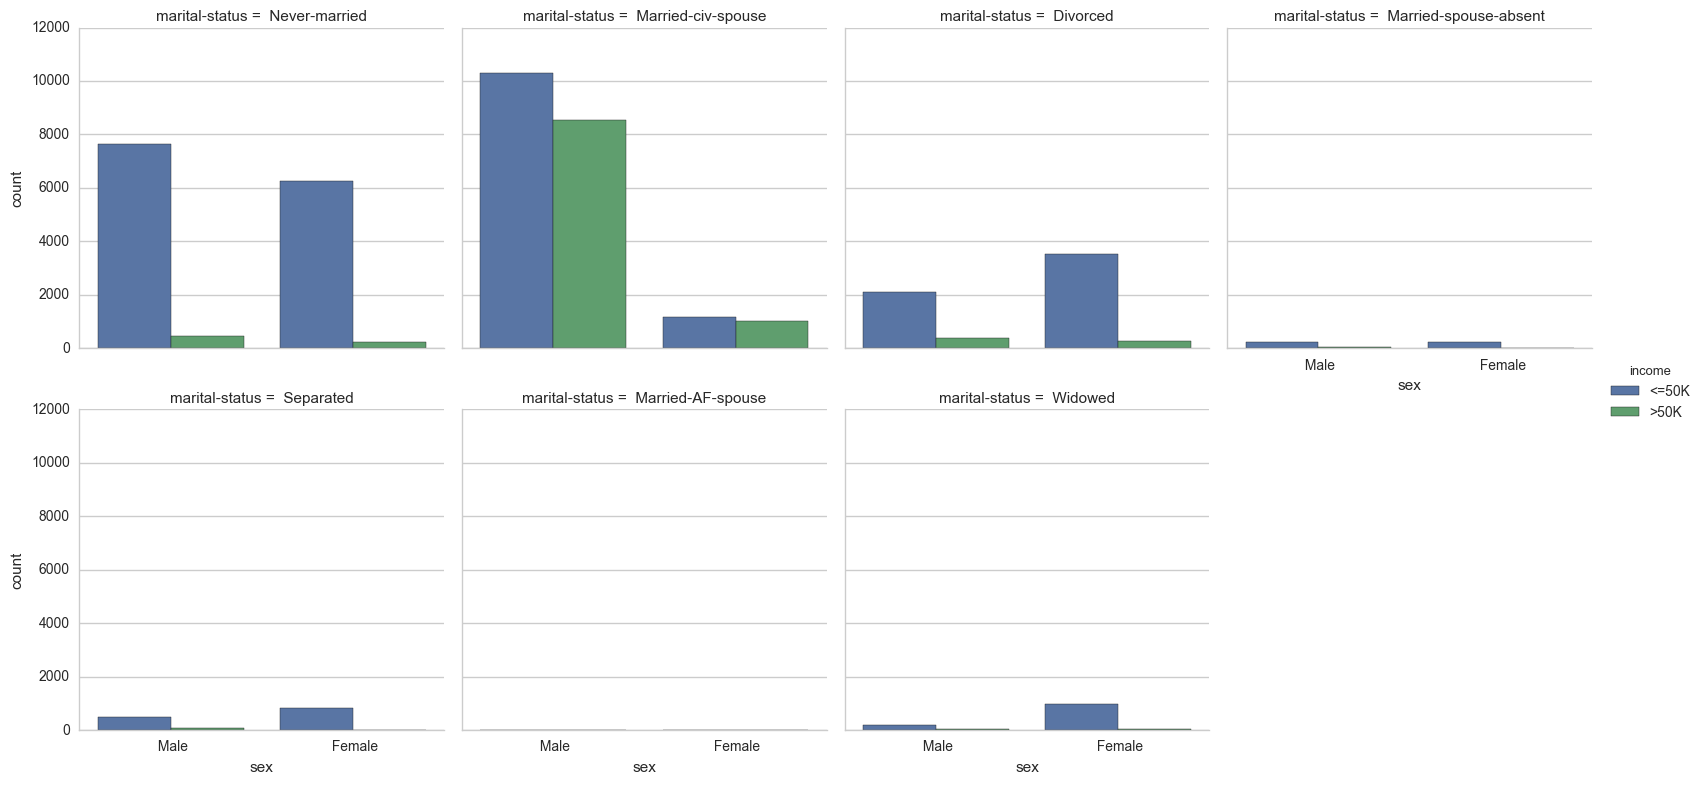

In [8]:
import seaborn as sns
sns.set(style='whitegrid', color_codes=True)
sns.factorplot('sex', col='marital-status', data=data,hue='income',kind='count',col_wrap=4)

We have an imbalanced proportion of individuals making more than $50k vs those making less, and will want to make sure the metric we're using for model evaluation is capturing how well the model is actually doing.

In this project we use the precision, recall, and F-beta scores.
[This article](http://machinelearningmastery.com/tactics-to-combat-imbalanced-classes-in-your-machine-learning-dataset/) gives some suggestions for imbalanced datasets.

A summary of it:

- collect more data if possible. A larger dataset might expose a different and perhaps more balanced perspective on the classes. More examples of minor classes may be useful later when we look at resampling your dataset.
- Use other metrices instead of accuracy.
- You can add copies of instances from the under-represented class called over-sampling (or more formally sampling with replacement), or
You can delete instances from the over-represented class, called under-sampling.
- **Try Generate Synthetic Samples**
- Try Different Algorithms: decision trees often perform well on imbalanced datasets.
- Try Penalized Models
- Try a Different Perspective


----
## Preparing the Data
Before data can be used as input for machine learning algorithms, it often must be cleaned, formatted, and restructured — this is typically known as **preprocessing**. Fortunately, for this dataset, there are no invalid or missing entries we must deal with, however, there are some qualities about certain features that must be adjusted. This preprocessing can help tremendously with the outcome and predictive power of nearly all learning algorithms.

### Transforming Skewed Continuous Features
A dataset may sometimes contain at least one feature whose values tend to lie near a single number, but will also have a non-trivial number of vastly larger or smaller values than that single number.  Algorithms can be sensitive to such distributions of values and can underperform if the range is not properly normalized. With the census dataset two features fit this description: '`capital-gain'` and `'capital-loss'`. 

Run the code cell below to plot a histogram of these two features. Note the range of the values present and how they are distributed.

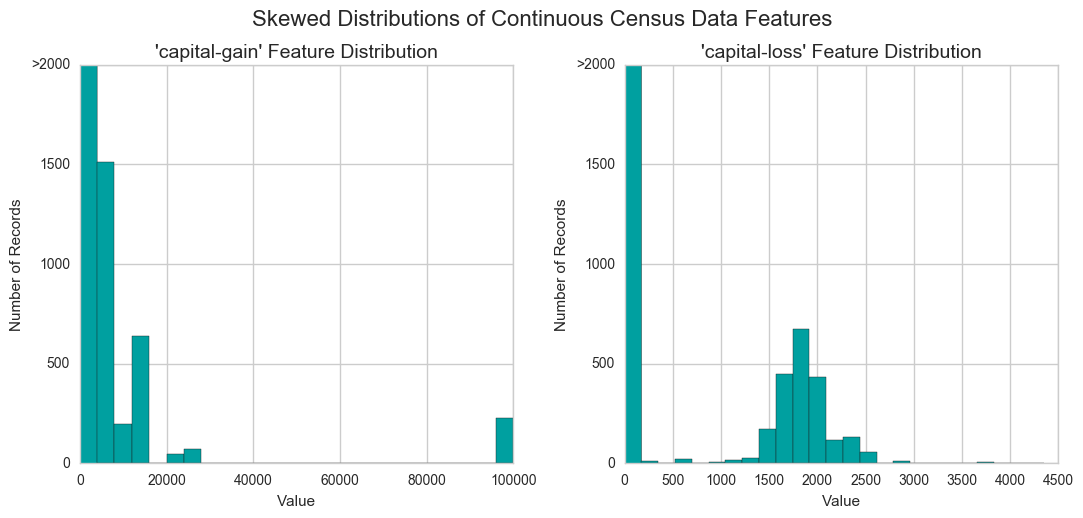

In [9]:
# Split the data into features and target label
income_raw = data['income']
features_raw = data.drop('income', axis = 1)

# Visualize skewed continuous features of original data
vs.distribution(data)

For highly-skewed feature distributions such as `'capital-gain'` and `'capital-loss'`, it is common practice to apply a <a href="https://en.wikipedia.org/wiki/Data_transformation_(statistics)">logarithmic transformation</a> on the data so that the very large and very small values do not negatively affect the performance of a learning algorithm. Using a logarithmic transformation significantly reduces the range of values caused by outliers. Care must be taken when applying this transformation however: The logarithm of `0` is undefined, so we must translate the values by a small amount above `0` to apply the the logarithm successfully.

Run the code cell below to perform a transformation on the data and visualize the results. Again, note the range of values and how they are distributed. 

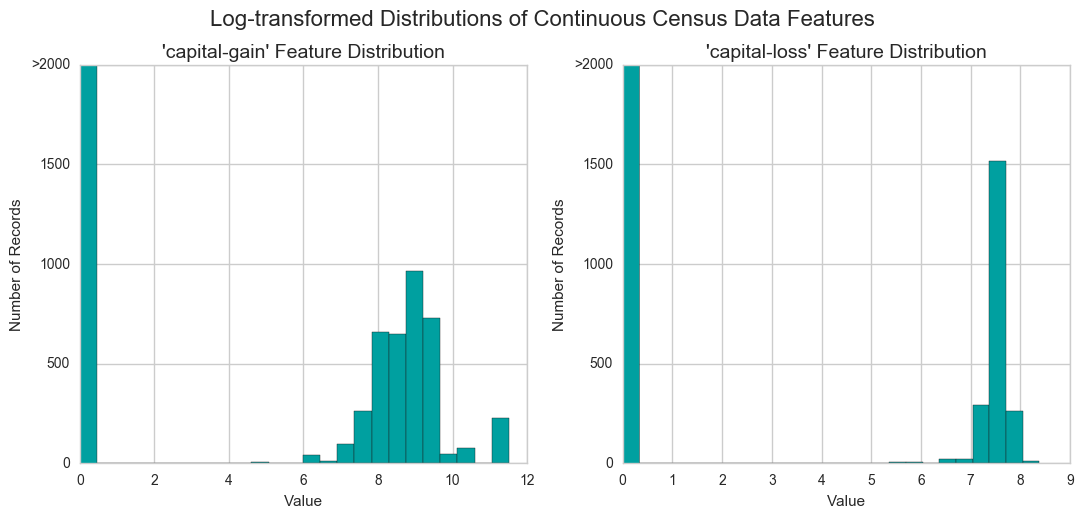

In [10]:
# Log-transform the skewed features
skewed = ['capital-gain', 'capital-loss']
features_raw[skewed] = data[skewed].apply(lambda x: np.log(x + 1))

# Visualize the new log distributions
vs.distribution(features_raw, transformed = True)

### Normalizing Numerical Features
In addition to performing transformations on features that are highly skewed, it is often good practice to perform some type of scaling on numerical features. Applying a scaling to the data does not change the shape of each feature's distribution (such as `'capital-gain'` or `'capital-loss'` above); however, normalization ensures that each feature is treated equally when applying supervised learners. Note that once scaling is applied, observing the data in its raw form will no longer have the same original meaning, as exampled below.

Run the code cell below to normalize each numerical feature. We will use [`sklearn.preprocessing.MinMaxScaler`](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html) for this.

In [11]:
# Import sklearn.preprocessing.StandardScaler
from sklearn.preprocessing import MinMaxScaler

# Initialize a scaler, then apply it to the features
scaler = MinMaxScaler()
numerical = ['age', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']
features_raw[numerical] = scaler.fit_transform(data[numerical])

# Show an example of a record with scaling applied
display(features_raw.head(n = 1))

,age,workclass,education_level,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country
0,0.30137,State-gov,Bachelors,0.8,Never-married,Adm-clerical,Not-in-family,White,Male,0.02174,0.0,0.397959,United-States


In [12]:
features_raw.head()

,age,workclass,education_level,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country
0,0.301370,State-gov,Bachelors,0.800000,Never-married,Adm-clerical,Not-in-family,White,Male,0.02174,0.0,0.397959,United-States
1,0.452055,Self-emp-not-inc,Bachelors,0.800000,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.00000,0.0,0.122449,United-States
2,0.287671,Private,HS-grad,0.533333,Divorced,Handlers-cleaners,Not-in-family,White,Male,0.00000,0.0,0.397959,United-States
3,0.493151,Private,11th,0.400000,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0.00000,0.0,0.397959,United-States
4,0.150685,Private,Bachelors,0.800000,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0.00000,0.0,0.397959,Cuba


### Implementation: Data Preprocessing

From the table in **Exploring the Data** above, we can see there are several features for each record that are non-numeric. Typically, learning algorithms expect input to be numeric, which requires that non-numeric features (called *categorical variables*) be converted. One popular way to convert categorical variables is by using the **one-hot encoding** scheme. One-hot encoding creates a _"dummy"_ variable for each possible category of each non-numeric feature. For example, assume `someFeature` has three possible entries: `A`, `B`, or `C`. We then encode this feature into `someFeature_A`, `someFeature_B` and `someFeature_C`.

|   | someFeature |                    | someFeature_A | someFeature_B | someFeature_C |
| :-: | :-: |                            | :-: | :-: | :-: |
| 0 |  B  |  | 0 | 1 | 0 |
| 1 |  C  | ----> one-hot encode ----> | 0 | 0 | 1 |
| 2 |  A  |  | 1 | 0 | 0 |

Additionally, as with the non-numeric features, we need to convert the non-numeric target label, `'income'` to numerical values for the learning algorithm to work. Since there are only two possible categories for this label ("<=50K" and ">50K"), we can avoid using one-hot encoding and simply encode these two categories as `0` and `1`, respectively. In code cell below, you will need to implement the following:
 - Use [`pandas.get_dummies()`](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.get_dummies.html?highlight=get_dummies#pandas.get_dummies) to perform one-hot encoding on the `'features_raw'` data.
 - Convert the target label `'income_raw'` to numerical entries.
   - Set records with "<=50K" to `0` and records with ">50K" to `1`.

In [13]:
# TODO: One-hot encode the 'features_raw' data using pandas.get_dummies()
features = pd.get_dummies(features_raw)

# TODO: Encode the 'income_raw' data to numerical values
income = income_raw.apply(lambda x: 1 if x==">50K" else 0)

# Print the number of features after one-hot encoding
encoded = list(features.columns)
print "{} total features after one-hot encoding.".format(len(encoded))

# Uncomment the following line to see the encoded feature names
print encoded

103 total features after one-hot encoding.
['age', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week', 'workclass_ Federal-gov', 'workclass_ Local-gov', 'workclass_ Private', 'workclass_ Self-emp-inc', 'workclass_ Self-emp-not-inc', 'workclass_ State-gov', 'workclass_ Without-pay', 'education_level_ 10th', 'education_level_ 11th', 'education_level_ 12th', 'education_level_ 1st-4th', 'education_level_ 5th-6th', 'education_level_ 7th-8th', 'education_level_ 9th', 'education_level_ Assoc-acdm', 'education_level_ Assoc-voc', 'education_level_ Bachelors', 'education_level_ Doctorate', 'education_level_ HS-grad', 'education_level_ Masters', 'education_level_ Preschool', 'education_level_ Prof-school', 'education_level_ Some-college', 'marital-status_ Divorced', 'marital-status_ Married-AF-spouse', 'marital-status_ Married-civ-spouse', 'marital-status_ Married-spouse-absent', 'marital-status_ Never-married', 'marital-status_ Separated', 'marital-status_ Widowed', 'occupation_ A

In [8]:
# We can also use sklearn's LabelEncoder to convert the non-numeric target labels. This would come in handy for performing multi-class predictions...

# from sklearn.preprocessing import LabelEncoder
# le = LabelEncoder()
# income = le.fit_transform(income_raw)

# # if needed we can reverse the transform
# print le.inverse_transform(income)

 In case you wanted to examine how many different values there are for the non-numeric features before encoding them, we could take a look with value_counts...

In [14]:
# look at first few non-numeric columns
for col in data.columns[:5]:
    if data[col].dtype == 'O':
        display(data[col].value_counts())

 Private             33307
 Self-emp-not-inc     3796
 Local-gov            3100
 State-gov            1946
 Self-emp-inc         1646
 Federal-gov          1406
 Without-pay            21
Name: workclass, dtype: int64

 HS-grad         14783
 Some-college     9899
 Bachelors        7570
 Masters          2514
 Assoc-voc        1959
 11th             1619
 Assoc-acdm       1507
 10th             1223
 7th-8th           823
 Prof-school       785
 9th               676
 12th              577
 Doctorate         544
 5th-6th           449
 1st-4th           222
 Preschool          72
Name: education_level, dtype: int64

 Married-civ-spouse       21055
 Never-married            14598
 Divorced                  6297
 Separated                 1411
 Widowed                   1277
 Married-spouse-absent      552
 Married-AF-spouse           32
Name: marital-status, dtype: int64

### Shuffle and Split Data
Now all _categorical variables_ have been converted into numerical features, and all numerical features have been normalized. As always, we will now split the data (both features and their labels) into training and test sets. 80% of the data will be used for training and 20% for testing.

Run the code cell below to perform this split.

In [15]:
# Import train_test_split
from sklearn.cross_validation import train_test_split

# Split the 'features' and 'income' data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, income, test_size = 0.2, random_state = 0)

# Show the results of the split
print "Training set has {} samples.".format(X_train.shape[0])
print "Testing set has {} samples.".format(X_test.shape[0])

Training set has 36177 samples.
Testing set has 9045 samples.


----
## Evaluating Model Performance
In this section, we will investigate four different algorithms, and determine which is best at modeling the data. Three of these algorithms will be supervised learners of your choice, and the fourth algorithm is known as a *naive predictor*.

### Metrics and the Naive Predictor
*CharityML*, equipped with their research, knows individuals that make more than \$50,000 are most likely to donate to their charity. Because of this, *CharityML* is particularly interested in predicting who makes more than \$50,000 accurately. It would seem that using **accuracy** as a metric for evaluating a particular model's performace would be appropriate. Additionally, identifying someone that *does not* make more than \$50,000 as someone who does would be detrimental to *CharityML*, since they are looking to find individuals willing to donate. Therefore, a model's ability to precisely predict those that make more than \$50,000 is *more important* than the model's ability to **recall** those individuals. We can use **F-beta score** as a metric that considers both precision and recall:

$$ F_{\beta} = (1 + \beta^2) \cdot \frac{precision \cdot recall}{\left( \beta^2 \cdot precision \right) + recall} $$

In particular, when $\beta = 0.5$, more emphasis is placed on precision. This is called the **F$_{0.5}$ score** (or F-score for simplicity).

Looking at the distribution of classes (those who make at most \$50,000, and those who make more), it's clear most individuals do not make more than \$50,000. This can greatly affect **accuracy**, since we could simply say *"this person does not make more than \$50,000"* and generally be right, without ever looking at the data! Making such a statement would be called **naive**, since we have not considered any information to substantiate the claim. It is always important to consider the *naive prediction* for your data, to help establish a benchmark for whether a model is performing well. That been said, using that prediction would be pointless: If we predicted all people made less than \$50,000, *CharityML* would identify no one as donors. 

### Question 1 - Naive Predictor Performace
*If we chose a model that always predicted an individual made more than \$50,000, what would that model's accuracy and F-score be on this dataset?*  
**Note:** You must use the code cell below and assign your results to `'accuracy'` and `'fscore'` to be used later.

In [16]:
# TODO: Calculate accuracy
accuracy = sum(income)/float(len(income))

# TODO: Calculate F-score using the formula above for beta = 0.5
precision=accuracy
recall=1
fscore = (1+0.25)*(precision*recall)/(0.25*precision+recall)

# Print the results 
print "Naive Predictor: [Accuracy score: {:.4f}, F-score: {:.4f}]".format(accuracy, fscore)

Naive Predictor: [Accuracy score: 0.2478, F-score: 0.2917]


###  Supervised Learning Models
**The following supervised learning models are currently available in** [`scikit-learn`](http://scikit-learn.org/stable/supervised_learning.html) **that you may choose from:**
- Gaussian Naive Bayes (GaussianNB)
- Decision Trees
- Ensemble Methods (Bagging, AdaBoost, Random Forest, Gradient Boosting)
- K-Nearest Neighbors (KNeighbors)
- Stochastic Gradient Descent Classifier (SGDC)
- Support Vector Machines (SVM)
- Logistic Regression

### Question 2 - Model Application
List three of the supervised learning models above that are appropriate for this problem that you will test on the census data. For each model chosen
- *Describe one real-world application in industry where the model can be applied.* (You may need to do research for this — give references!)
- *What are the strengths of the model; when does it perform well?*
- *What are the weaknesses of the model; when does it perform poorly?*
- *What makes this model a good candidate for the problem, given what you know about the data?*

**Answer: ** From the flowchart given by [sklearn](http://scikit-learn.org/stable/tutorial/machine_learning_map/)
<img src="files/ml_map.png"> I choose Logistic Regression, support vector machines and Random Forest.



Logistic Regression:
==

**Applications: **
One example: Predicting Customer Satisfaction in a Student-Operated Restaurant.

Larasati, Aisyah, Camille DeYong, and Lisa Slevitch. "The application of neural network and logistics regression models on predicting customer satisfaction in a student-operated restaurant." Procedia-Social and Behavioral Sciences 65 (2012): 94-99.


** Advantages:**
1). It is fast, especially when the dimension gets large.
2). Logistic regression is intrinsically simple, it has low variance and so is less prone to over-fitting.
3). It can optimize the multi-class (multinomial) problems directly.
4). With L1 regulazation, it can lead to a sparse model.
5). It can work when the features are correlated.

**Disadvantages:** 
1). The parameter estimation procedure of logistic regression relies heavily on having an adequate number of samples. The rule of thumb is at least 10 events per variable. So if you have an event with a 1% chance, and 10 variables, you want a sample size of around 10,000. 

**Why choose Logistic Regression?** 
It is simply and fast. The features may be correlated and logistic regression can handle this problem.


Support Vector Machines
===
It  showed good results in the medical diagnostics, optical character recognition, electric load forecasting and other fields.

One real-world ** application ** example is prediction of common diseases. Support vector machine modeling is a promising classification approach for detecting persons with common diseases such as diabetes and pre-diabetes in the population. 

Reference: Yu, Wei, et al. "Application of support vector machine modeling for prediction of common diseases: the case of diabetes and pre-diabetes." BMC Medical Informatics and Decision Making 10.1 (2010): 16.

**Advantages of SVMs:** 
1). It has a regularisation parameter, which makes the user think about avoiding over-fitting. 2). It uses the kernel trick, (though the kernel trick is not unique to SVMs), so it can work well even if the data is not linearly separable in the feature space. And you can build in expert knowledge about the problem via engineering the kernel.
3). An SVM is defined by a convex optimisation problem (no local minima) for which there are efficient methods (e.g. SMO). 
4). It works well for high-dimensional problem, for example, in text classification problems.


**Disadvantages of SVMs: **
1). Have to tune the parameter, face with the selection of  kernels and the kernel function parameters;
2). Hard to inteprete.
3). "However, from a practical point of view perhaps the most serious problem with SVMs is the high algorithmic complexity and extensive memory requirements of the required quadratic programming in large-scale tasks."
Horváth (2003) in Suykens et al. p 392

** Why choose SVMs? **
There are 103 features, SVMs can help to prevent overfitting.


** References: **
1.[Edwin Chen's blog](http://blog.echen.me/2011/04/27/choosing-a-machine-learning-classifier/)
2.[Advantages and disadvantages of SVM](http://stats.stackexchange.com/questions/24437/advantages-and-disadvantages-of-svm)


Random Forest:
==

**Application*:

Use Random Forest to diagnose Aircraft Engine Fault.

Yan, Weizhong. "Application of random forest to aircraft engine fault diagnosis." Computational Engineering in Systems Applications, IMACS Multiconference on. Vol. 1. IEEE, 2006.
    
**Advantages:**
1). It is one of the most accurate learning algorithms available. For many data sets, it produces a highly accurate classifier.
2). It runs efficiently on large databases. It is fast to build. Even faster to predict!
3). It can handle thousands of input variables without variable deletion.
4). It gives estimates of what variables are important in the classification.
5). It generates an internal unbiased estimate of the generalization error as the forest building.
6). It has methods for balancing error in class population unbalanced data sets. 
Generated forests can be saved for future use on other data. 
7). Prototypes are computed that give information about the relation between the variables and the classification. 
8). It computes proximities between pairs of cases that can be used in clustering, locating outliers, or (by scaling) give interesting views of the data. 
9). The capabilities of the above can be extended to unlabeled data, leading to unsupervised clustering, data views and outlier detection. 
10). It offers an experimental method for detecting variable interactions.
11). It doesn't require cross-validation.
12). Ability to handle data without preprocessing (data does not need to be rescaled, transformed, or modified).
13). It is resistant to outliers, and is automatic handling of missing values.


**Disadvantages:** 
1).Lost explainability.
2). Random forests have been observed to overfit for some datasets with noisy classification/regression tasks.
3). For data including categorical variables with different number of levels, random forests are biased in favor of those attributes with more levels. Therefore, the variable importance scores from random forest are not reliable for this type of data.


**Why is it chosen?**
1). It is a highly accurate classifier.
2). The dataset (income greater than 50,000 and less than) is skewed. Random Forest can deal with this.


link: https://www.quora.com/What-are-the-advantages-of-different-classification-algorithms
https://sebastianraschka.com/faq/docs/model-selection-in-datascience.html
http://scikit-learn.org/stable/auto_examples/classification/plot_classifier_comparison.html
https://docs.microsoft.com/en-us/azure/machine-learning/machine-learning-algorithm-choice

https://jessesw.com/XG-Boost/ (uses our census income dataset)
http://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/

### Implementation - Creating a Training and Predicting Pipeline
To properly evaluate the performance of each model you've chosen, it's important that you create a training and predicting pipeline that allows you to quickly and effectively train models using various sizes of training data and perform predictions on the testing data. Your implementation here will be used in the following section.
In the code block below, you will need to implement the following:
 - Import `fbeta_score` and `accuracy_score` from [`sklearn.metrics`](http://scikit-learn.org/stable/modules/classes.html#sklearn-metrics-metrics).
 - Fit the learner to the sampled training data and record the training time.
 - Perform predictions on the test data `X_test`, and also on the first 300 training points `X_train[:300]`.
   - Record the total prediction time.
 - Calculate the accuracy score for both the training subset and testing set.
 - Calculate the F-score for both the training subset and testing set.
   - Make sure that you set the `beta` parameter!

In [17]:
# TODO: Import two metrics from sklearn - fbeta_score and accuracy_score
from sklearn.metrics import fbeta_score
from sklearn.metrics import accuracy_score

def train_predict(learner, sample_size, X_train, y_train, X_test, y_test): 
    '''
    inputs:
       - learner: the learning algorithm to be trained and predicted on
       - sample_size: the size of samples (number) to be drawn from training set
       - X_train: features training set
       - y_train: income training set
       - X_test: features testing set
       - y_test: income testing set
    '''
    
    results = {}
    
    # TODO: Fit the learner to the training data using slicing with 'sample_size'
    start = time() # Get start time
    learner = learner.fit(X_train[0:sample_size],y_train[0:sample_size])
    end = time() # Get end time
    
    # TODO: Calculate the training time
    results['train_time'] = end-start
        
    # TODO: Get the predictions on the test set,
    #       then get predictions on the first 300 training samples
    start = time() # Get start time
    predictions_test = learner.predict(X_test)
    predictions_train = learner.predict(X_train[:300])
    end = time() # Get end time
    
    # TODO: Calculate the total prediction time
    results['pred_time'] = end-start
            
    # TODO: Compute accuracy on the first 300 training samples
    results['acc_train'] = sum(predictions_train==y_train[0:300])/300.0
        
    # TODO: Compute accuracy on test set
    results['acc_test'] = float(sum(predictions_test==y_test))/len(y_test)
    
    # TODO: Compute F-score on the the first 300 training samples
    results['f_train'] = fbeta_score(y_train[:300], predictions_train, 0.5)
        
    # TODO: Compute F-score on the test set
    results['f_test'] = fbeta_score(y_test,predictions_test, 0.5)
       
    # Success
    print "{} trained on {} samples.".format(learner.__class__.__name__, sample_size)
        
    # Return the results
    return results


#######
for i in results.items():
    print i[0]
    display(pd.DataFrame(i[1]).rename(columns={0:'1%', 1:'10%', 2:'100%'}))

### Implementation: Initial Model Evaluation
In the code cell, you will need to implement the following:
- Import the three supervised learning models you've discussed in the previous section.
- Initialize the three models and store them in `'clf_A'`, `'clf_B'`, and `'clf_C'`.
  - Use a `'random_state'` for each model you use, if provided.
  - **Note:** Use the default settings for each model — you will tune one specific model in a later section.
- Calculate the number of records equal to 1%, 10%, and 100% of the training data.
  - Store those values in `'samples_1'`, `'samples_10'`, and `'samples_100'` respectively.

**Note:** Depending on which algorithms you chose, the following implementation may take some time to run!

LogisticRegression trained on 361 samples.
LogisticRegression trained on 3617 samples.
LogisticRegression trained on 36177 samples.


/Users/XiaofeiZheng/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:1074: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


SVC trained on 361 samples.
SVC trained on 3617 samples.
SVC trained on 36177 samples.
RandomForestClassifier trained on 361 samples.
RandomForestClassifier trained on 3617 samples.
RandomForestClassifier trained on 36177 samples.


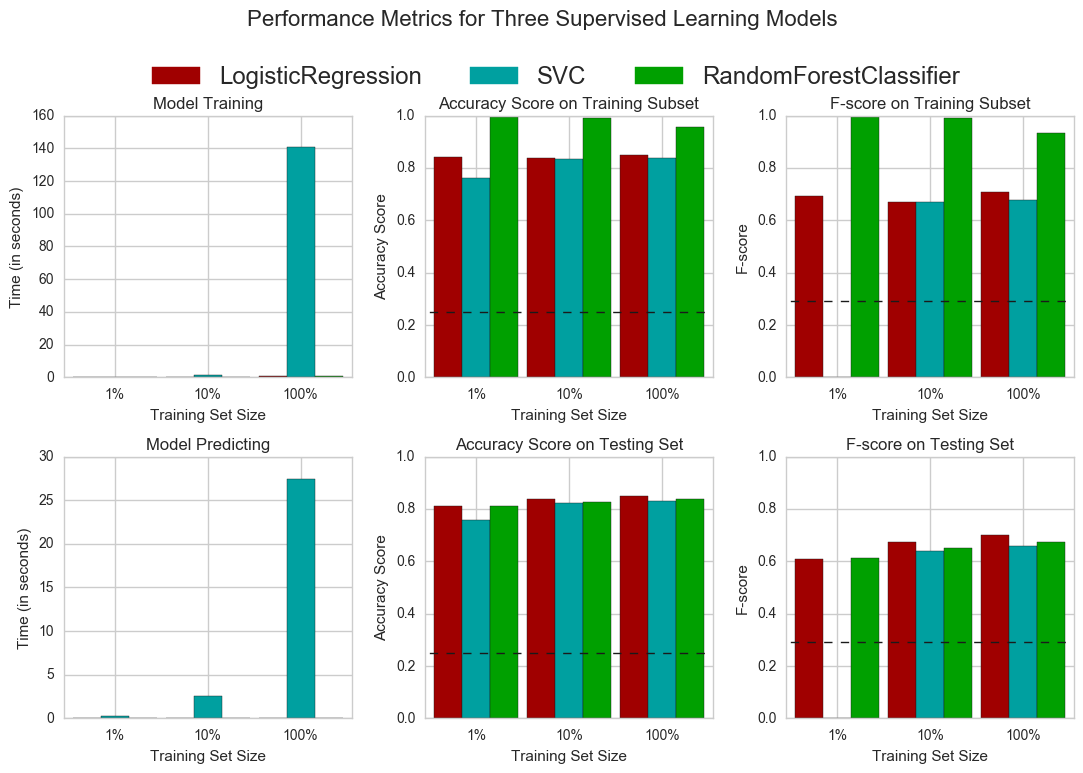

In [18]:
# TODO: Import the three supervised learning models from sklearn
#from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
#sklearn.svm.SVC(C=1.0, kernel='rbf', degree=3, gamma='auto', coef0=0.0, shrinking=True, probability=False, tol=0.001, cache_size=200, class_weight=None, verbose=False, max_iter=-1, decision_function_shape=None, random_state=None)
#from sklearn.linear_model import SGDClassifier
#clf = SGDClassifier(loss="hinge", penalty="l2")
#clf.fit(X, y)
#from sklearn.ensemble import AdaBoostClassifier
# AdaBoostClassifier(base_estimator=None, n_estimators=50, learning_rate=1.0, algorithm='SAMME.R', random_state=None)
#from sklearn.neighbors import KNeighborsClassifier

# TODO: Initialize the three models
clf_A=LogisticRegression(random_state=1)
clf_B=SVC(random_state=1)
clf_C=RandomForestClassifier(random_state=1)

# clf_A = LogisticRegression()
# clf_B = SGDClassifier()
# clf_C = AdaBoostClassifier()
# clf_D = SVC() #very slow for training
# clf_E=GaussianNB() #fast in training but low accuracy
# clf_F=KNeighborsClassifier() #a little slower than adaboost and less accurate than adaboost
# clf_G=RandomForestClassifier()

# TODO: Calculate the number of samples for 1%, 10%, and 100% of the training data
samples_1 =int(len(X_train)*0.01)
samples_10 = int(len(X_train)*0.1)
samples_100 = len(X_train)

# Collect results on the learners
results = {}
for clf in [ clf_A,clf_B, clf_C]:
    clf_name = clf.__class__.__name__
    results[clf_name] = {}
    for i, samples in enumerate([samples_1, samples_10, samples_100]):
        results[clf_name][i]=train_predict(clf, samples, X_train, y_train, X_test, y_test)

# Run metrics visualization for the three supervised learning models chosen
vs.evaluate(results, accuracy, fscore)

LogisticRegression trained on 361 samples.
LogisticRegression trained on 3617 samples.
LogisticRegression trained on 36177 samples.
RandomForestClassifier trained on 361 samples.
RandomForestClassifier trained on 3617 samples.
RandomForestClassifier trained on 36177 samples.


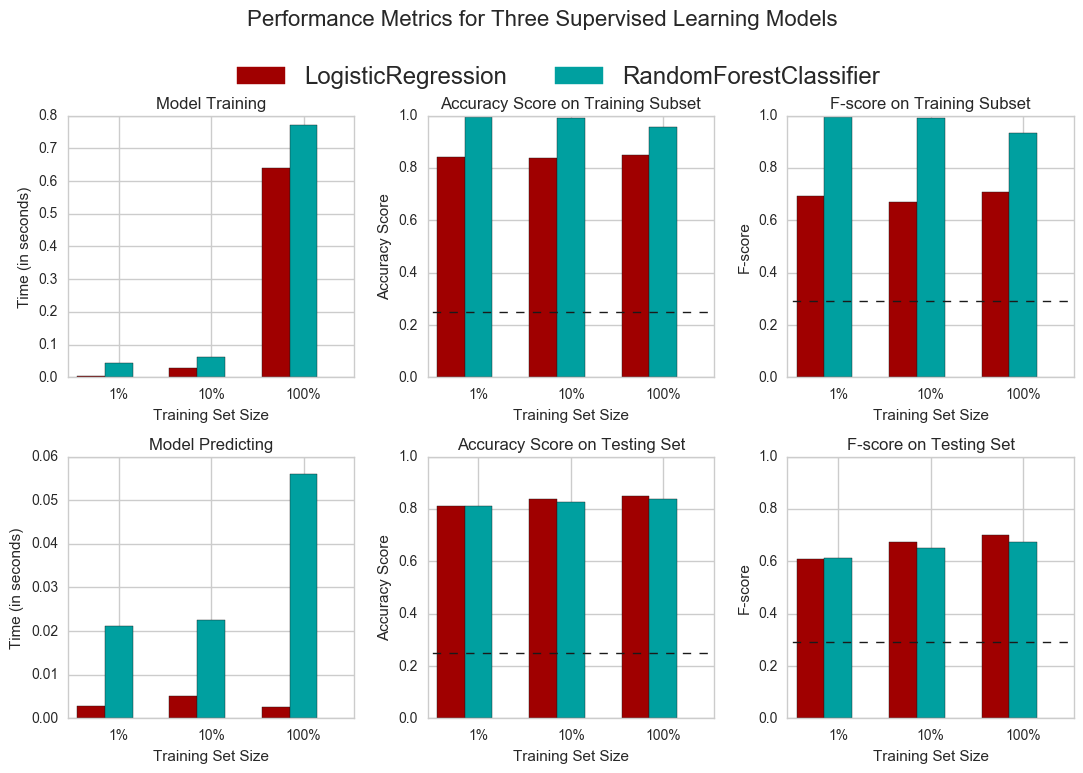

In [19]:
# TODO: Import the three supervised learning models from sklearn
#from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
#sklearn.svm.SVC(C=1.0, kernel='rbf', degree=3, gamma='auto', coef0=0.0, shrinking=True, probability=False, tol=0.001, cache_size=200, class_weight=None, verbose=False, max_iter=-1, decision_function_shape=None, random_state=None)
#from sklearn.linear_model import SGDClassifier
#clf = SGDClassifier(loss="hinge", penalty="l2")
#clf.fit(X, y)
#from sklearn.ensemble import AdaBoostClassifier
# AdaBoostClassifier(base_estimator=None, n_estimators=50, learning_rate=1.0, algorithm='SAMME.R', random_state=None)
#from sklearn.neighbors import KNeighborsClassifier

# TODO: Initialize the three models
clf_A=LogisticRegression(random_state=1)
#clf_B=SVC(random_state=1)
clf_C=RandomForestClassifier(random_state=1)
# clf_A = LogisticRegression()
# clf_B = SGDClassifier()
# clf_C = AdaBoostClassifier()
# clf_D = SVC() #very slow for training
# clf_E=GaussianNB() #fast in training but low accuracy
# clf_F=KNeighborsClassifier() #a little slower than adaboost and less accurate than adaboost
# clf_G=RandomForestClassifier()

# TODO: Calculate the number of samples for 1%, 10%, and 100% of the training data
samples_1 =int(len(X_train)*0.01)
samples_10 = int(len(X_train)*0.1)
samples_100 = len(X_train)

# Collect results on the learners
results = {}
for clf in [ clf_A, clf_C]:
    clf_name = clf.__class__.__name__
    results[clf_name] = {}
    for i, samples in enumerate([samples_1, samples_10, samples_100]):
        results[clf_name][i]=train_predict(clf, samples, X_train, y_train, X_test, y_test)

# Run metrics visualization for the three supervised learning models chosen
vs.evaluate(results, accuracy, fscore)

----
## Improving Results
In this final section, you will choose from the three supervised learning models the *best* model to use on the student data. You will then perform a grid search optimization for the model over the entire training set (`X_train` and `y_train`) by tuning at least one parameter to improve upon the untuned model's F-score. 

### Question 3 - Choosing the Best Model
*Based on the evaluation you performed earlier, in one to two paragraphs, explain to *CharityML* which of the three models you believe to be most appropriate for the task of identifying individuals that make more than \$50,000.*  
**Hint:** Your answer should include discussion of the metrics, prediction/training time, and the algorithm's suitability for the data.

**Answer: **
SVC’s computational time would grow much faster than the other two methods when the size of the dataset increases. Also, its accuracy scores and F-scores on training and testing sets are the worst one among the three methods. So SVC is not the optimal mode for our dataset. 

Comparison of logistic regression and the random forest: when we only take 1% of the training dataset, the computational time of random forest is shorter. However, when we increase the size of the dataset, logistic regression outperforms. As for the accuracy, random forest is more accurate on the training data, but the two models have almost the same accuracy on the test dataset. The F-score of the random forest model is higher on the training data, but on the test dataset, logistic regression outperforms.  The logistic regression model is unlikely to be overfitting. 

Since our dataset is skewed, not only the accuracy has to be considered, but also the F-score. 

Considering all of those aspects, the most appropriate model is the Logistic regression model.


### Question 4 - Describing the Model in Layman's Terms
*In one to two paragraphs, explain to *CharityML*, in layman's terms, how the final model chosen is supposed to work. Be sure that you are describing the major qualities of the model, such as how the model is trained and how the model makes a prediction. Avoid using advanced mathematical or technical jargon, such as describing equations or discussing the algorithm implementation.*

**Answer: ** 
Since it is more likely for a person to be a donor of CharityML if his or her income is more than 50,000 dollars.  The task of the logistic regression model is used to  each person's information (such as age, workclass, education_level and so on) to predict how possible his or her impore is more than 50,000 dollars. The model studies from  existing data on persons whose income information is known to us. Based on the people's features, the model would output a weight, the bigger the weight is, the more likely we predict that the person's income is more than 50,000 dollars.

After the model is trained,  the second step is predicting whether new person's income (we don't know his or her income) would be more than 50,000 dollars. The features of the new person will be input to the model and the model will output a probability and we set a threshold, for example, if the probability is more than 0.5, then the new person will be a donor. 

We can adjust the threshold. If you don't want to miss someone who may donate, then decrease the threshold. Even if the person doesn't have an income more than 50,000 dollars, it won't hurt. 

[This article](https://rayli.net/blog/data/top-10-data-mining-algorithms-in-plain-english/) gives  plain explanation to some popular algorithms. 

### Implementation: Model Tuning
Fine tune the chosen model. Use grid search (`GridSearchCV`) with at least one important parameter tuned with at least 3 different values. You will need to use the entire training set for this. In the code cell below, you will need to implement the following:
- Import [`sklearn.grid_search.GridSearchCV`](http://scikit-learn.org/0.17/modules/generated/sklearn.grid_search.GridSearchCV.html) and [`sklearn.metrics.make_scorer`](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.make_scorer.html).
- Initialize the classifier you've chosen and store it in `clf`.
 - Set a `random_state` if one is available to the same state you set before.
- Create a dictionary of parameters you wish to tune for the chosen model.
 - Example: `parameters = {'parameter' : [list of values]}`.
 - **Note:** Avoid tuning the `max_features` parameter of your learner if that parameter is available!
- Use `make_scorer` to create an `fbeta_score` scoring object (with $\beta = 0.5$).
- Perform grid search on the classifier `clf` using the `'scorer'`, and store it in `grid_obj`.
- Fit the grid search object to the training data (`X_train`, `y_train`), and store it in `grid_fit`.

**Note:** Depending on the algorithm chosen and the parameter list, the following implementation may take some time to run!

In [20]:
# TODO: Import 'GridSearchCV', 'make_scorer', and any other necessary libraries
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import make_scorer
# TODO: Initialize the classifier
clf = LogisticRegression(random_state=2017)

# TODO: Create the parameters list you wish to tune
parameters = {
    'C': np.logspace(-2, 2, 13),
    'penalty':['l1', 'l2']
    }




# TODO: Make an fbeta_score scoring object
scorer = make_scorer(fbeta_score,beta=0.5, greater_is_better=True)

# TODO: Perform grid search on the classifier using 'scorer' as the scoring method
#grid_obj = GridSearchCV(clf, param_grid, scoring= scorer)
grid_obj = GridSearchCV(clf, parameters, cv=5,
                        scoring=scorer, n_jobs=-1)
# TODO: Fit the grid search object to the training data and find the optimal parameters
grid_fit = grid_obj.fit(X_train, y_train)

# Get the estimator
best_clf = grid_fit.best_estimator_

# Make predictions using the unoptimized and model
predictions = (clf.fit(X_train, y_train)).predict(X_test)
best_predictions = best_clf.predict(X_test)

# Report the before-and-afterscores
print "Unoptimized model\n------"
print "Accuracy score on testing data: {:.4f}".format(accuracy_score(y_test, predictions))
print "F-score on testing data: {:.4f}".format(fbeta_score(y_test, predictions, beta = 0.5))
print "\nOptimized Model\n------"
print "Final accuracy score on the testing data: {:.4f}".format(accuracy_score(y_test, best_predictions))
print "Final F-score on the testing data: {:.4f}".format(fbeta_score(y_test, best_predictions, beta = 0.5))

Unoptimized model
------
Accuracy score on testing data: 0.8483
F-score on testing data: 0.6993

Optimized Model
------
Final accuracy score on the testing data: 0.8491
Final F-score on the testing data: 0.7002


In [22]:
# Pro tip: Look at grid scores
# You can also look at the scores of each of the parameter settings with grid_obj.grid_scores_
# (or grid_obj.cv_results_ in sklearn 0.18)...

from IPython.display import display
display(pd.DataFrame(grid_obj.grid_scores_))

# If you keep the default cv parameter on the grid search object grid_obj, 
# the grid search will default to a stratified K-Fold cross validation with 3 folds.

,parameters,mean_validation_score,cv_validation_scores
0,"{u'penalty': u'l1', u'C': 0.01}",0.654811,"[0.648375451264, 0.678039612549, 0.64104444770..."
1,"{u'penalty': u'l2', u'C': 0.01}",0.668121,"[0.661671143786, 0.687650645116, 0.6542591267,..."
2,"{u'penalty': u'l1', u'C': 0.0215443469003}",0.683392,"[0.673946306858, 0.704610753865, 0.67146282973..."
3,"{u'penalty': u'l2', u'C': 0.0215443469003}",0.673753,"[0.669155260611, 0.688876727322, 0.66249130132..."
4,"{u'penalty': u'l1', u'C': 0.0464158883361}",0.701951,"[0.69092614931, 0.720042277712, 0.698158849617..."
5,"{u'penalty': u'l2', u'C': 0.0464158883361}",0.681142,"[0.676482562084, 0.692194403535, 0.66952731235..."
6,"{u'penalty': u'l1', u'C': 0.1}",0.704678,"[0.695731627725, 0.720761559383, 0.69969692976..."
7,"{u'penalty': u'l2', u'C': 0.1}",0.685532,"[0.676691729323, 0.701559020045, 0.67660088602..."
8,"{u'penalty': u'l1', u'C': 0.215443469003}",0.704570,"[0.69664222308, 0.718253455626, 0.699149771092..."
9,"{u'penalty': u'l2', u'C': 0.215443469003}",0.690810,"[0.682322243966, 0.706401766004, 0.68155034699..."


In [23]:
print best_clf

LogisticRegression(C=4.6415888336127775, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l1', random_state=2017,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)


### Question 5 - Final Model Evaluation
_What is your optimized model's accuracy and F-score on the testing data? Are these scores better or worse than the unoptimized model? How do the results from your optimized model compare to the naive predictor benchmarks you found earlier in **Question 1**?_  
**Note:** Fill in the table below with your results, and then provide discussion in the **Answer** box.

#### Results:

|     Metric     | Benchmark Predictor | Unoptimized Model | Optimized Model |
| :------------: | :-----------------: | :---------------: | :-------------: | 
| Accuracy Score |     0.2478          |    0.8483         |   0.8491        |
| F-score        |     0.2917          |    0.6993         |   0.7002        |


**Answer: **  

The optimized model's accuracy and F-score on the testing data are 0.8491 and 0.7002. They are better than the unoptimized model. They are improved significantly compared with the benchmarks. 

----
## Feature Importance

An important task when performing supervised learning on a dataset like the census data we study here is determining which features provide the most predictive power. By focusing on the relationship between only a few crucial features and the target label we simplify our understanding of the phenomenon, which is most always a useful thing to do. In the case of this project, that means we wish to identify a small number of features that most strongly predict whether an individual makes at most or more than \$50,000.

Choose a scikit-learn classifier (e.g., adaboost, random forests) that has a `feature_importance_` attribute, which is a function that ranks the importance of features according to the chosen classifier.  In the next python cell fit this classifier to training set and use this attribute to determine the top 5 most important features for the census dataset.

### Question 6 - Feature Relevance Observation
When **Exploring the Data**, it was shown there are thirteen available features for each individual on record in the census data.  
_Of these thirteen records, which five features do you believe to be most important for prediction, and in what order would you rank them and why?_

**Answer:**
 age > education-num > occupation > hours-per-week > capital-gain 

1. People's working experience is related to their  ages. So age in some sense affects the income. But it is not the leading factors. 

2. Higher Education level can increase the income level to some extension. Most people with high-grad or lower education levels tend to be in the lower-income group. Education-num is correlated to the education_level. So it effects the income in the same way as the education_level.

3. I found for people make more than 50k, their occupations focus more on Prof-specialty, Exec-managerial and  the other 12 occupations. While for those with less than 50K income, the occupations are various.  So I thinkg occupation is the most important feature.

4.  There is a common character among people making more than 50K: almost all of them work at least 40 hours. For most people who work less than 40 hours, they are more likely to be in the lower-income group.

5. Capital-gain affects people's income. So it is also an important feature.

In [24]:
features_raw.columns

Index([u'age', u'workclass', u'education_level', u'education-num',
       u'marital-status', u'occupation', u'relationship', u'race', u'sex',
       u'capital-gain', u'capital-loss', u'hours-per-week', u'native-country'],
      dtype='object')

In [25]:
data[data['income']=="<=50K"]

,age,workclass,education_level,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,Bachelors,13.0,Never-married,Adm-clerical,Not-in-family,White,Male,2174.0,0.0,40.0,United-States,<=50K
1,50,Self-emp-not-inc,Bachelors,13.0,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.0,0.0,13.0,United-States,<=50K
2,38,Private,HS-grad,9.0,Divorced,Handlers-cleaners,Not-in-family,White,Male,0.0,0.0,40.0,United-States,<=50K
3,53,Private,11th,7.0,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0.0,0.0,40.0,United-States,<=50K
4,28,Private,Bachelors,13.0,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0.0,0.0,40.0,Cuba,<=50K
5,37,Private,Masters,14.0,Married-civ-spouse,Exec-managerial,Wife,White,Female,0.0,0.0,40.0,United-States,<=50K
6,49,Private,9th,5.0,Married-spouse-absent,Other-service,Not-in-family,Black,Female,0.0,0.0,16.0,Jamaica,<=50K
12,23,Private,Bachelors,13.0,Never-married,Adm-clerical,Own-child,White,Female,0.0,0.0,30.0,United-States,<=50K
13,32,Private,Assoc-acdm,12.0,Never-married,Sales,Not-in-family,Black,Male,0.0,0.0,50.0,United-States,<=50K
14,34,Private,7th-8th,4.0,Married-civ-spouse,Transport-moving,Husband,Amer-Indian-Eskimo,Male,0.0,0.0,45.0,Mexico,<=50K


In [26]:
data[data['income']=='>50K']

,age,workclass,education_level,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
7,52,Self-emp-not-inc,HS-grad,9.0,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.0,0.0,45.0,United-States,>50K
8,31,Private,Masters,14.0,Never-married,Prof-specialty,Not-in-family,White,Female,14084.0,0.0,50.0,United-States,>50K
9,42,Private,Bachelors,13.0,Married-civ-spouse,Exec-managerial,Husband,White,Male,5178.0,0.0,40.0,United-States,>50K
10,37,Private,Some-college,10.0,Married-civ-spouse,Exec-managerial,Husband,Black,Male,0.0,0.0,80.0,United-States,>50K
11,30,State-gov,Bachelors,13.0,Married-civ-spouse,Prof-specialty,Husband,Asian-Pac-Islander,Male,0.0,0.0,40.0,India,>50K
18,43,Self-emp-not-inc,Masters,14.0,Divorced,Exec-managerial,Unmarried,White,Female,0.0,0.0,45.0,United-States,>50K
19,40,Private,Doctorate,16.0,Married-civ-spouse,Prof-specialty,Husband,White,Male,0.0,0.0,60.0,United-States,>50K
24,56,Local-gov,Bachelors,13.0,Married-civ-spouse,Tech-support,Husband,White,Male,0.0,0.0,40.0,United-States,>50K
42,57,Federal-gov,Bachelors,13.0,Married-civ-spouse,Prof-specialty,Husband,Black,Male,0.0,0.0,40.0,United-States,>50K
48,47,Private,Prof-school,15.0,Married-civ-spouse,Prof-specialty,Wife,White,Female,0.0,1902.0,60.0,Honduras,>50K


### Implementation - Extracting Feature Importance
Choose a `scikit-learn` supervised learning algorithm that has a `feature_importance_` attribute availble for it. This attribute is a function that ranks the importance of each feature when making predictions based on the chosen algorithm.

In the code cell below, you will need to implement the following:
 - Import a supervised learning model from sklearn if it is different from the three used earlier.
 - Train the supervised model on the entire training set.
 - Extract the feature importances using `'.feature_importances_'`.

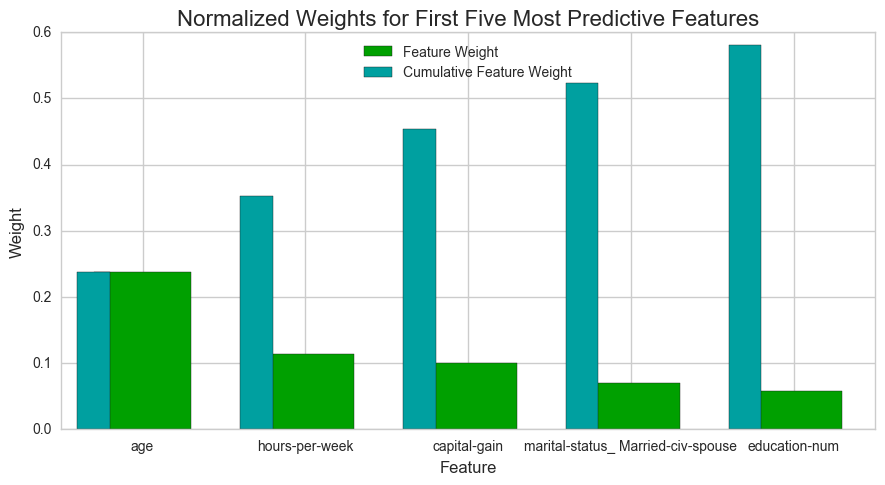

In [27]:
# TODO: Import a supervised learning model that has 'feature_importances_'

# TODO: Train the supervised model on the training set 
model = RandomForestClassifier(random_state=1)
model.fit(X_train,y_train)

# TODO: Extract the feature importances
importances = model.feature_importances_

# Plot
vs.feature_plot(importances, X_train, y_train)

In [28]:
#Find important features from logistic regression model
from sklearn.linear_model import LogisticRegression
model = LogisticRegression().fit(X_train, y_train)

coefs = model.coef_.ravel()
coefs = pd.DataFrame({'Coef': coefs, 'Odds Ratio': np.exp(coefs)})
coefs.index = X_train.columns

display(coefs.sort_values('Odds Ratio', ascending=False)[:10])

,Coef,Odds Ratio
capital-gain,18.590313,1.184870e+08
capital-loss,2.657013,1.425365e+01
hours-per-week,2.609884,1.359747e+01
education-num,1.682740,5.380277e+00
age,1.673601,5.331333e+00
marital-status_ Married-AF-spouse,1.306229,3.692225e+00
education_level_ Prof-school,1.199814,3.319499e+00
marital-status_ Married-civ-spouse,1.061433,2.890511e+00
native-country_ France,1.035557,2.816673e+00
education_level_ Doctorate,0.952543,2.592294e+00


### Question 7 - Extracting Feature Importance

Observe the visualization created above which displays the five most relevant features for predicting if an individual makes at most or above \$50,000.  
_How do these five features compare to the five features you discussed in **Question 6**? If you were close to the same answer, how does this visualization confirm your thoughts? If you were not close, why do you think these features are more relevant?_

**Answer:** The most important features in the random forest models are age > hours-per-week > capital-gain > martial-status_Married-civ-spouse > education-num. My guess was age > education-num > occupation > hours-per-week > capital-gain. So the feature I missed was the matrial-status. And occupation is not that important in the random forest model. Martial status is  important and closed related to the income. The reason is probably as follows: 1) Most people tend never married tend to be very young, so they don't have much working experience and hence their income is low. 2) People in married status can focus more on their work and make more. 



### Feature Selection
How does a model perform if we only use a subset of all the available features in the data? With less features required to train, the expectation is that training and prediction time is much lower — at the cost of performance metrics. From the visualization above, we see that the top five most important features contribute more than half of the importance of **all** features present in the data. This hints that we can attempt to *reduce the feature space* and simplify the information required for the model to learn. The code cell below will use the same optimized model you found earlier, and train it on the same training set *with only the top five important features*. 

In [29]:
# Import functionality for cloning a model
from sklearn.base import clone

# Reduce the feature space
X_train_reduced = X_train[X_train.columns.values[(np.argsort(importances)[::-1])[:5]]]
X_test_reduced = X_test[X_test.columns.values[(np.argsort(importances)[::-1])[:5]]]

# Train on the "best" model found from grid search earlier
clf = (clone(best_clf)).fit(X_train_reduced, y_train)

# Make new predictions
reduced_predictions = clf.predict(X_test_reduced)

# Report scores from the final model using both versions of data
print "Final Model trained on full data\n------"
print "Accuracy on testing data: {:.4f}".format(accuracy_score(y_test, best_predictions))
print "F-score on testing data: {:.4f}".format(fbeta_score(y_test, best_predictions, beta = 0.5))
print "\nFinal Model trained on reduced data\n------"
print "Accuracy on testing data: {:.4f}".format(accuracy_score(y_test, reduced_predictions))
print "F-score on testing data: {:.4f}".format(fbeta_score(y_test, reduced_predictions, beta = 0.5))

Final Model trained on full data
------
Accuracy on testing data: 0.8491
F-score on testing data: 0.7002

Final Model trained on reduced data
------
Accuracy on testing data: 0.8347
F-score on testing data: 0.6678


### Question 8 - Effects of Feature Selection
*How does the final model's F-score and accuracy score on the reduced data using only five features compare to those same scores when all features are used?*  
*If training time was a factor, would you consider using the reduced data as your training set?*

**Answer:** The F-score reduces from 0.7002 to 0.6678, and the accuracy is decreased from 0.8491 to 0.8347 when we reduces the feature space. Since the training time of the logistic regression model is not a problem, the full feature space should be used to train the model. However, if the training time of a model is a concern, we may sacrifice the metrics a little and choose the model trained by the reduced feature space. This choice can happen only when the metrics don't become too bad.

Note: The results are clearly worse than those generated using the full list of features, although this might be acceptable if we had a much larger dataset and computational cost were a bigger issue.

Still, feature reduction is a great way to fight the [curse of dimensionality](http://www.galvanize.com/learn/learn-to-code/curse-dimensionality-manage/).

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  
**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.